In [1]:
import numpy as np
import math
import scipy.stats as ss
import matplotlib.pyplot as plt
from itertools import product

# Problem 1 with only one type of customer

In [27]:
class ShuttleDispatching:
    
    
    def __init__(self, K, At, cf, ch, gamma, state):
        #
        #K = The capacity of a shuttle if it is dispatched.
        #At = A random variable giving the number of customers arriving during time interval t. 
        #cf = The cost of dispatching a shuttle.
        #ch = The cost per customer left waiting per time period.
        #gamma = discount rate γ
        #the number of State, which is set to 200, i.e from 0 to 200 np.range(201)
        
        
        # CAUTION!!!!!!!!!!! 
        #the value function we dealt with in this problem is the cost
        # which is the smaller the better!!!!!!!!!!!!!
        
        
        self.K = K
        #this envirment is too trivial, only five case with each 1/5 probbability
        self.At_case = At[0]
        self.At_mass = At[1]
        self.cf = cf
        self.ch = ch
        self.gamma = gamma
        self.states = state
    
    
    #this is one step evaluation for the policy value V^{pi'} under a new policy pi
    # policyValue: the value function under certain policy pi', which could be different from the pi
    # policy pi, under which we want to estimate 
    def Qfunction(self, policy, policyValue):
        cache = np.zeros((len(self.states), 5))
        for i in range(5):
            arrival = i+1
            temp = arrival + self.states - self.K*policy
            newStates = np.maximum(np.minimum(temp.astype(int), len(self.states)-1),0)
            cache[:, i] = newStates*self.ch + self.gamma * policyValue[newStates] + self.cf*policy
        return cache.dot(self.At_mass)
    
    #this is only used for value iteration, for one step
    def valueIterOneStep(self, curValue):
        cache = np.zeros((len(self.states), 2))
        #for action NOT picking a shuttle
        cache[:, 0] = self.Qfunction(np.zeros(len(self.states)), curValue)
            
        #for action PICKING a shuttle   
        cache[:, 1] = self.Qfunction(np.ones(len(self.states)), curValue)
        
        #note here we have positive cost, and it is a minimizing problem, so take minimum across all actions
        newValue = np.minimum(cache[:,0], cache[:,1])
        return newValue
        
    def policyIterOneStep(self, curPolicy, curPolicyValue, policyValueIter):
        
        #input:
        #curPolicy: the is indeed a new policy pi, by applying this policy several times to curPolicyValue
        # we could esimate the newPolicyValue, i.e the value under this new policy pi'
        #curPolicyValue: some policy value from some other previous policy (from last iteration)
        #policyValueIter: the number of iteration that will be used to estimate the new policy value V^pi
        
        #output
        #nextPolicy pi': the greedy policy that based on the new policy value V^pi
        #curPolicyValue: the policy value V^pi (not pi')
        
        ######################
        ## evalustion step  ##
        ######################
        iter = 1
        for _ in range(policyValueIter):
            nextPolicyValue = self.Qfunction(curPolicy ,curPolicyValue)
            curPolicyValue = nextPolicyValue
        
        ##################
        ## greedy step  ##
        ##################
        #now we do the calculation conditioning on each action, each is the same as in valueIterOneStep
        cache = np.zeros((len(self.states), 2))
        #for action NOT picking a shuttle
        cache[:, 0] = self.Qfunction(np.zeros(len(self.states)), curPolicyValue)
            
        #for action PICKING a shuttle   
        cache[:, 1] = self.Qfunction(np.ones(len(self.states)), curPolicyValue)
        
        
        #nonpick >= pick, value 1, which represent pick action (becareful about the cost function)
        nextPolicy = cache[:,0] >= cache[:,1]
        return nextPolicy, curPolicyValue
        
        
    def enumeration(self, T):
        #fig, ax = plt.subplots(1,1)
        curValue = np.zeros(len(self.states))
        for ind in range(T):
            curValue = self.valueIterOneStep(curValue)
            #if ind % 10 == 0:
            #    ax.plot(np.arange(len(self.states)), curValue)
        return curValue
        
    def valueIteration(self):
        #fig, ax = plt.subplots(1,1)
        curValue = np.zeros(len(self.states))
        iterNum = 1
        while True:
            nextValue = self.valueIterOneStep(curValue)
            if np.max(np.absolute(nextValue - curValue)) < 10**-6:
                break
            curValue = nextValue
         #   if iterNum % 20 == 0:
         #      ax.plot(np.arange(len(self.states)), curValue)
            iterNum += 1
        #print(iterNum)
        #plt.show()
        return nextValue, iterNum
        
    def policyIteration(self, policyValueIter):
        #fig, ax = plt.subplots(1,1)
        curValue = np.zeros(len(self.states))
        curPolicy = np.ones(len(self.states))
        iterNum = 1
        while True:
 
            nextPolicy, nextValue = self.policyIterOneStep(curPolicy, curValue, policyValueIter)
            
            # the nextValue is the updated value based on the previous policy
            # nextPolicy is the greedy policy based on the updated value(of previous policy)
            #print(nextPolicy)
            #print(nextValue)
            valueUnderNewPolicy = self.Qfunction(nextPolicy, nextValue)
            if np.max(np.absolute(valueUnderNewPolicy - nextValue))< 10**-6:
                break
            curValue = nextValue
            curPolicy = nextPolicy
           
            #if iterNum % 10 == 0:
            #    ax.plot(np.arange(len(self.states)), curValue)
            iterNum += 1
        #print(iterNum)
        #plt.show()
        return nextPolicy, nextValue, iterNum
        
        
        

### (a)(b)(c) please see the following plot

In [28]:
at = np.array([[1,2,3,4,5], [0.2,0.2,0.2,0.2,0.2]])
model = ShuttleDispatching(K = 15, At = at, cf=100, ch=2, gamma=0.95, state = np.arange(201))

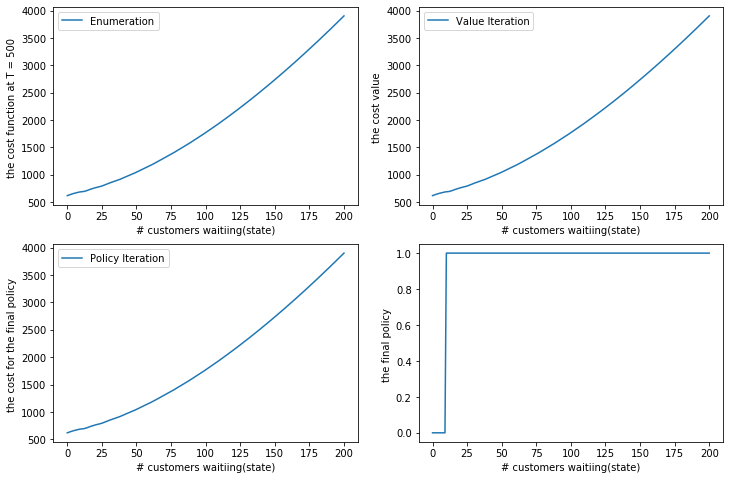

In [29]:
policy, value, iterNum = model.policyIteration(10)
valu2 = model.valueIteration()
value3 = model.enumeration(500)

fig, ([[ax, ax0], [ax1, ax2]]) = plt.subplots(2,2)

fig.set_figwidth(12)
fig.set_figheight(8)

ax.plot(model.states,value3, label='Enumeration')
ax.set_xlabel('# customers waitiing(state)')
ax.set_ylabel('the cost function at T = 500 ')
ax.legend()


ax0.plot(model.states,value, label='Value Iteration')
ax0.set_xlabel('# customers waitiing(state)')
ax0.set_ylabel('the cost value ')
ax0.legend()

ax1.plot(model.states,value, label='Policy Iteration')
ax1.set_xlabel('# customers waitiing(state)')
ax1.set_ylabel('the cost for the final policy ')
ax1.legend()

ax2.plot(model.states,policy)
ax2.set_xlabel('# customers waitiing(state)')
ax2.set_ylabel('the final policy ')


plt.show()

### Below, I showed a graph of number of iterations used to evaluate policy value versus number of iteration for the policy gradient to converge. It is obvious that if we evalute the policy value with more iterations, which will yield better approximatiion, the faster the policy gradient would converge

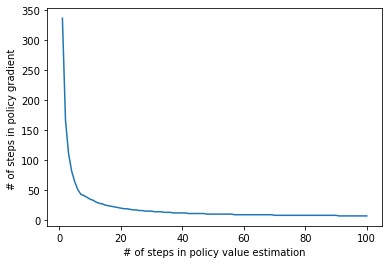

In [30]:
iterNum = []
for i in np.arange(100)+1:
    _,_,temp =  model.policyIteration(i)
    iterNum.append(temp)
    
fig, ax = plt.subplots(1,1)
ax.plot(np.arange(100)+1,iterNum)
ax.set_xlabel('# of steps in policy value estimation')
ax.set_ylabel('# of steps in policy gradient ')

plt.show()

# Problem 2 ( Due to computation complexity, only consider two types of customers)

In [7]:

class ShuttleDispatching_MultiClass:
    
    
    
    def __init__(self, K, cf, ch, gamma, maxNum):
        #
        #K = The capacity of a shuttle if it is dispatched.
        #At = A random variable giving the number of customers arriving during time interval t. 
        #cf = The cost of dispatching a shuttle.
        #ch = a list of reresenting the cost per customer left waiting per time period for different type.
        #gamma = discount rate γ
        #maxNum, which is set to 100
        
        
        # CAUTION!!!!!!!!!!! 
        #the value function we dealt with in this problem is the cost
        # which is the smaller the better!!!!!!!!!!!!!
        
        
        self.K = K
        self.cf = cf
        self.ch = ch
        self.typeCust = len(ch)
        self.gamma = gamma
        self.states = np.ones(self.typeCust).astype(int) * (maxNum+1)
        self.maxNum = maxNum
    
    #this is one step evaluation for the policy value V^{pi'} under a new policy pi
    # policyValue: the value function under certain policy pi', which could be different from the pi
    # policy pi, under which we want to estimate 
    def Qfunction(self, policy, policyValue):
        cache = np.zeros(self.states)
        # the big loop for arrival scenarios, arrival is a tuple of length self.typeCust
        for arrival in product(np.arange(5)+1, repeat = self.typeCust):
            #loop over all the indices for the state
            for ind, value in np.ndenumerate(cache):
                # loop over all the type, high cost comes first!!!!!!
                remove = policy[ind]*self.K
                newind = []
                for t in range(self.typeCust):
                    #this gives the new number after arrival
                    new = max(min(arrival[t] + ind[t], self.maxNum),0)
                    
                    if remove > 0 and remove >= new:
                        remove -= new
                        new = 0
                    elif remove > 0 and remove < new:
                        remove = 0
                        new -= remove
                    newind.append(new)
                newind = tuple(newind)
                #print(ind)
                #print(newind)
                #print(policyValue[newind])
                #print(self.cf * policy[ind])
                #print(np.array(newind).dot(self.ch))
                cache[ind] += (self.gamma * policyValue[newind] + self.cf * policy[ind] + np.array(newind).dot(self.ch))/5**self.typeCust
        return cache
    
    #this is only used for value iteration, for one step
    def valueIterOneStep(self, curValue):
        #for action NOT picking a shuttle
        temp0 = self.Qfunction(np.zeros(self.states), curValue)
            
        #for action PICKING a shuttle   
        temp1 = self.Qfunction(np.ones(self.states), curValue)
        
        #note here we have positive cost, and it is a minimizing problem, so take minimum across all actions
        newValue = np.minimum(temp0, temp1)
        return newValue
        
    def policyIterOneStep(self, curPolicy, curPolicyValue, policyValueIter):
        
        #input:
        #curPolicy: the is indeed a new policy pi, by applying this policy several times to curPolicyValue
        # we could esimate the newPolicyValue, i.e the value under this new policy pi'
        #curPolicyValue: some policy value from some other previous policy (from last iteration)
        #policyValueIter: the number of iteration that will be used to estimate the new policy value V^pi
        
        #output
        #nextPolicy pi': the greedy policy that based on the new policy value V^pi
        #curPolicyValue: the policy value V^pi (not pi')
        
        ######################
        ## evalustion step  ##
        ######################
        iter = 1
        for _ in range(policyValueIter):
            nextPolicyValue = self.Qfunction(curPolicy ,curPolicyValue)
            curPolicyValue = nextPolicyValue
        
        ##################
        ## greedy step  ##
        ##################
        #now we do the calculation conditioning on each action, each is the same as in valueIterOneStep
        #for action NOT picking a shuttle
        temp0 = self.Qfunction(np.zeros(self.states), curPolicyValue)
            
        #for action PICKING a shuttle   
        temp1 = self.Qfunction(np.ones(self.states), curPolicyValue)
        
        
        #nonpick >= pick, value 1, which represent pick action (becareful about the cost function)
        nextPolicy = temp0 >= temp1
        return nextPolicy, curPolicyValue
        
        
    def enumeration(self, T):
        #fig, ax = plt.subplots(1,1)
        curValue = np.zeros(self.states)
        for ind in range(T):
            curValue = self.valueIterOneStep(curValue)
            #if ind % 10 == 0:
            #    ax.plot(np.arange(len(self.states)), curValue)
        return curValue
        
    def valueIteration(self):
        #fig, ax = plt.subplots(1,1)
        curValue = np.zeros(self.states)
        iterNum = 1
        while True:
            nextValue = self.valueIterOneStep(curValue)
            if np.max(np.absolute(nextValue - curValue)) < 10**-6:
                break
            curValue = nextValue
            if iterNum % 20 == 0:
                print(iterNum)
         #      ax.plot(np.arange(len(self.states)), curValue)
            iterNum += 1
        print(iterNum)
        #plt.show()
        return nextValue, iterNum
        
    def policyIteration(self, policyValueIter):
        #fig, ax = plt.subplots(1,1)
        curValue = np.zeros(self.states)
        curPolicy = np.ones(self.states)
        iterNum = 1
        while True:
            #print(iterNum)
            nextPolicy, nextValue = self.policyIterOneStep(curPolicy, curValue, policyValueIter)
            
            # the nextValue is the updated value based on the previous policy
            # nextPolicy is the greedy policy based on the updated value(of previous policy)
            #print(nextPolicy)
            #print(nextValue)
            valueUnderNewPolicy = self.Qfunction(nextPolicy, nextValue)
            if np.max(np.absolute(valueUnderNewPolicy - nextValue))< 10**-6:
                break
            curValue = nextValue
            curPolicy = nextPolicy
           
            if iterNum % 10 == 0:
                print(iterNum)
            #    ax.plot(np.arange(len(self.states)), curValue)
            iterNum += 1
        print(iterNum)
        #plt.show()
        return nextPolicy, nextValue, iterNum
        
        

In [8]:
model = ShuttleDispatching_MultiClass( K = 30 , cf = 100, ch = [2,1], gamma = 0.95, maxNum = 100)

### (a) the value from enumeration T = 500

In [49]:
value0 = model.enumeration(T = 500)

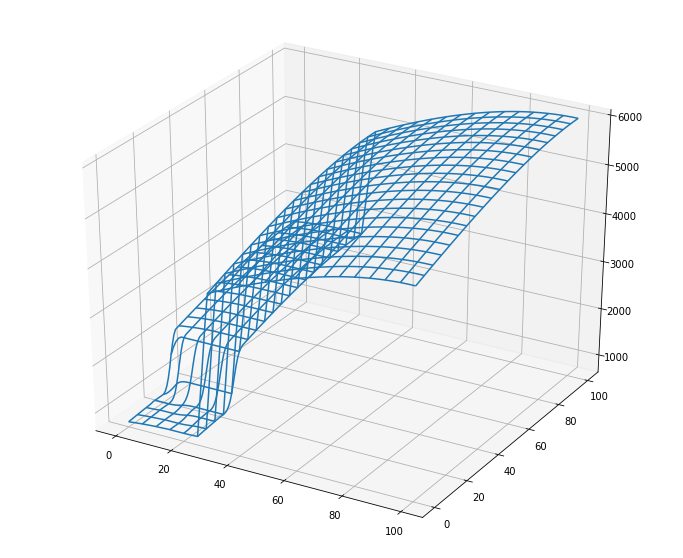

In [78]:
xind = np.array([[j for _ in  range(model.maxNum+1)] for j in range(model.maxNum+1)])
yind = np.array([[j for j in  range(model.maxNum+1)] for _ in range(model.maxNum+1)])
zind = value0


from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
fig = plt.figure()
fig.set_size_inches(12,10)

ax = fig.add_subplot(111, projection='3d')

# Plot a basic wireframe.
ax.plot_wireframe(xind, yind, zind, rstride=5, cstride=5)

plt.show()

### (b) the value from value iteration

In [5]:
value1, iterNum = model.valueIteration()

20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
382


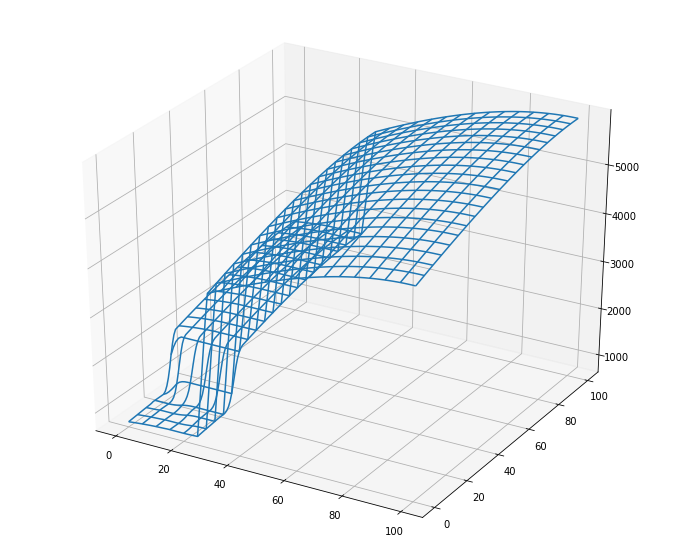

In [77]:
xind = np.array([[j for _ in  range(model.maxNum+1)] for j in range(model.maxNum+1)])
yind = np.array([[j for j in  range(model.maxNum+1)] for _ in range(model.maxNum+1)])
zind = value1


from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
fig = plt.figure()
fig.set_size_inches(12, 10)

ax = fig.add_subplot(111, projection='3d')


# Plot a basic wireframe.
ax.plot_wireframe(xind, yind, zind, rstride=5, cstride=5)

plt.show()

### (c) the policy and value from the policy iteration

In [9]:
policy, value2, iterNum = model.policyIteration(3)

10
20
30
40
50
60
70
80
90
100
110
120
127


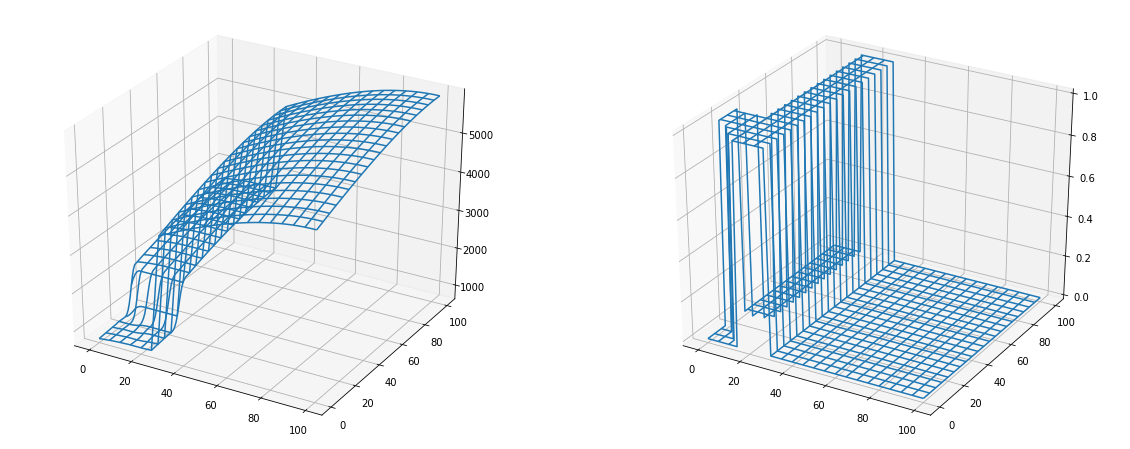

In [76]:
xind = np.array([[j for _ in  range(model.maxNum+1)] for j in range(model.maxNum+1)])
yind = np.array([[j for j in  range(model.maxNum+1)] for _ in range(model.maxNum+1)])
zind = value2


from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, subplot_kw={'projection':'3d'})
fig.set_size_inches(20, 8)

#ax1 = fig.add_subplot(111, projection='3d')
#ax2 = fig.add_subplot(121, projection='3d')

# Plot a basic wireframe.
ax1.plot_wireframe(xind, yind, zind, rstride=5, cstride=5)
ax2.plot_wireframe(xind, yind, policy, rstride=5, cstride=5)

plt.show()